In [1]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
from functions.functions import load_data_forGridSearch, feature_scaling_forGridSearch

import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model_fn = '../Models/ANN/model_20190605-111346.pb'
# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def)

In [3]:
layers = [op.name for op in graph.get_operations() if op.type=='Dense' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

Number of layers 0
Total number of feature channels: 0


In [4]:
[op.name for op in graph.get_operations() if 'input' in op.name]

[u'input', u'import/dense_1_input_1']

In [5]:
op = graph.get_operation_by_name('import/dense_1_input_2' )

KeyError: "The name 'import/dense_1_input_2' refers to an Operation not in the graph."

In [6]:
# This is only used to display R2 during training, not used for updating weights or final evaluation 

def R2_score(y_true, y_pred):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    R2 = 1. - tf.div(numerator, denominator)
    R2_mean = tf.reduce_mean(R2)
    return R2_mean

In [7]:
model_k_fn = '../Models/ANN/model_20190408-141040.hdf5'
from keras.models import load_model
model = load_model(model_k_fn, custom_objects={'R2_score': R2_score})
model.metrics = []
model.metrics_names = ['loss']
model.metrics_tensors = []
model.save('../Models/ANN/model_wometric.hdf5')
X_train, y_train = load_data_forGridSearch("../Data", "train")

Using TensorFlow backend.


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
print(scaler.data_max_)

[ 0.10116394  0.12329492  0.22204605 34.98629779 34.98400654 34.9886772
 34.77294318 34.76295438 34.75049642 34.96385064 34.93235877]


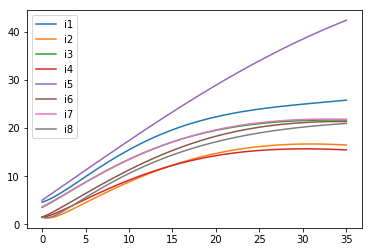

In [9]:
# checking current ramps on individual coils
import matplotlib.pyplot as plt
%matplotlib inline

n_steps = 100
p = np.zeros((n_steps,3), np.float)

p = np.tile([6.33876990e-05, -4.48958620e-03,  1.70704782e-01], (n_steps,1))
plt.figure(figsize=(6,4))
for c in range(8):
    currents = np.zeros((n_steps,8), np.float)
    currents[:,c] = np.linspace(0,35,n_steps)
    x = np.concatenate((p, currents), axis=1)
    _, x = feature_scaling_forGridSearch(X_train, x)
    #plt.subplot(8,1,c+1)

    import mpem
    cal = mpem.ElectromagnetCalibration('/home/samuelch/tesla_ws/src/mag_control/mpem/cal/C_Mag_Calibration_06-25-2015.yaml')
    fields = np.zeros((n_steps, 3))
    for i in xrange(n_steps):
        fields[i,:] = np.squeeze(cal.fieldAtPoint(currents[i,:][:,np.newaxis], p[0,:]))
    norm_factor = np.linalg.norm(fields[-1,:])/35.
    plt.plot(currents[:,c], np.linalg.norm(model.predict(x), axis=1)/norm_factor)
    #plt.plot(currents[:,c], np.linalg.norm(fields, axis=1)/norm_factor, '--')
plt.legend(['i{}'.format(i+1) for i in range(8)])

# Calculating Gradients

In [10]:
def jacobian_tensorflow(x):    
    jacobian_matrix = []
    for m in range(model.output.shape[1]):
        # We iterate over the M elements of the output vector
        grad_func = tf.gradients(model.output[:, m], model.input)
        gradients = sess.run(grad_func, feed_dict={model.input: x})
        jacobian_matrix.append(gradients[0][0,:])
        
    return np.array(jacobian_matrix)

In [11]:
currents = 5*np.random.rand(1,8)
x = np.concatenate((np.zeros((1,3), np.float), currents), axis=1)
_, x = feature_scaling_forGridSearch(X_train, x)

In [12]:
dy_dx = jacobian_tensorflow(x)
minmax_scale = MinMaxScaler().fit(X_train)
dy_dx_scaled = dy_dx.dot(np.diag(minmax_scale.scale_))

In [13]:
dy_dx_scaled[:,3:]

array([[-2.82663644e-03, -5.65519165e-04,  3.79305988e-04,
         4.11169964e-04,  2.03679775e-03,  7.94506609e-04,
         3.26481361e-04, -1.01181744e-03],
       [-3.02979923e-04, -1.07986944e-03, -2.17839146e-03,
        -9.58706144e-04,  7.26829324e-05,  8.57455674e-04,
         2.43557630e-03,  7.95558689e-04],
       [ 1.56650819e-03, -8.50333061e-04,  1.52823368e-03,
        -8.52889375e-04,  8.55991668e-04, -9.91700677e-04,
         1.22724565e-03, -1.37246325e-03]])

In [14]:
cal.fieldCurrentJacobian(np.zeros((3,), np.float))

array([[-1.89568274e-03, -9.16674333e-04,  1.97807969e-04,
         8.52853976e-04,  1.69893084e-03,  9.93745929e-04,
         2.27963163e-04, -1.03266410e-03],
       [-5.17883176e-06, -1.11527539e-03, -1.76011018e-03,
        -1.24261051e-03,  3.57609911e-05,  1.01564586e-03,
         1.70413761e-03,  9.89250135e-04],
       [ 1.13093035e-03, -8.83927760e-04,  1.41458082e-03,
        -8.68121407e-04,  1.26466109e-03, -8.00432736e-04,
         1.12820855e-03, -9.42557360e-04]])

In [15]:
cal.gradientAtPoint(currents.T, np.zeros((3,)))

array([[-0.03936661, -0.02051639, -0.01619985],
       [-0.02051639,  0.02756007,  0.04370249],
       [-0.01619985,  0.04370249,  0.01180654]])

In [16]:
np.sum(np.diag(dy_dx_scaled[:,0:3]))

-0.11524947024567947

# Checking ANN Prediction Speed

In [22]:
%%timeit -r 1000 -n 10
model.predict(np.random.rand(1,11))

10 loops, best of 1000: 665 µs per loop
